In [ ]:
system("ln -s /home/ec2-user/anaconda3/envs/R_Beta/bin/x86_64-conda_cos6-linux-gnu-c++ /home/ec2-user/anaconda3/bin/x86_64-conda_cos6-linux-gnu-c++")
system("ln -s /home/ec2-user/anaconda3/envs/R_Beta/bin/x86_64-conda_cos6-linux-gnu-cc /home/ec2-user/anaconda3/bin/x86_64-conda_cos6-linux-gnu-cc")

In [ ]:
install.packages('pROC')
install.packages('Matching')
knitr::opts_chunk$set(echo = TRUE)

In [1]:
wdpath = paste(path.expand("~"),'SageMaker/mimic-code/notebooks/aline/awsathena',sep='/')
setwd(wdpath)
dataset = read.csv(file="aline_data.csv",head=TRUE,sep=",")

In [2]:
dataset$icustay_id = factor(dataset$icustay_id)
dataset$day_28_flag = factor(dataset$day_28_flag, levels=c(0,1))
dataset$gender = factor(dataset$gender, levels=c("F","M"))
dataset$day_icu_intime = factor(dataset$day_icu_intime)
dataset$hour_icu_intime = factor(dataset$hour_icu_intime)
dataset$icu_hour_flag = factor(dataset$icu_hour_flag, levels=c(0,1))
#dataset$sepsis_flag = factor(dataset$sepsis_flag, levels=c(0,1))
dataset$sedative_flag = factor(dataset$sedative_flag, levels=c(0,1))
dataset$fentanyl_flag = factor(dataset$fentanyl_flag, levels=c(0,1))
dataset$midazolam_flag = factor(dataset$midazolam_flag, levels=c(0,1))
dataset$propofol_flag = factor(dataset$propofol_flag, levels=c(0,1))
#dataset$dilaudid_flag = factor(dataset$dilaudid_flag, levels=c(0,1))
dataset$chf_flag = factor(dataset$chf_flag, levels=c(0,1))
dataset$afib_flag = factor(dataset$afib_flag, levels=c(0,1))
dataset$renal_flag = factor(dataset$renal_flag, levels=c(0,1))
dataset$liver_flag = factor(dataset$liver_flag, levels=c(0,1))
dataset$copd_flag = factor(dataset$copd_flag, levels=c(0,1))
dataset$cad_flag = factor(dataset$cad_flag, levels=c(0,1))
dataset$stroke_flag = factor(dataset$stroke_flag, levels=c(0,1))
dataset$malignancy_flag = factor(dataset$malignancy_flag, levels=c(0,1))
dataset$respfail_flag = factor(dataset$respfail_flag, levels=c(0,1))
dataset$ards_flag = factor(dataset$ards_flag, levels=c(0,1))
dataset$pneumonia_flag = factor(dataset$pneumonia_flag, levels=c(0,1))

# custom factor
dataset$service_surg = factor( dataset$service_unit == 'SURG', levels=c(FALSE,TRUE))

In [3]:
# we could impute data if we like - e.g. the below imputes the mean
# we currently do complete case analysis however
imputeFlag = 0
if (imputeFlag != 0){
  print("Imputing missing data for some features...")
for (col in c("weight_first","temp_first","spo2_first",
              "bun_first","creatinine_first", "chloride_first", "hgb_first",
              "platelet_first", "potassium_first", "sodium_first", "tco2_first", "wbc_first"))
{
  print(paste("Imputing data for: ", col))
  dataset[is.na(dataset[,col]),col] = mean(dataset[,col], na.rm=TRUE)
}
}

In [4]:
# subselect the variables
dat = dataset[,c("aline_flag",
                  "age","gender","weight_first","sofa_first","service_surg",
                  "day_icu_intime","hour_icu_intime",
                  "chf_flag","afib_flag","renal_flag",
                  "liver_flag","copd_flag","cad_flag","stroke_flag",
                  "malignancy_flag","respfail_flag",
                  "map_first","hr_first","temp_first","spo2_first",
                  "bun_first","chloride_first","creatinine_first",
                  "hgb_first","platelet_first",
                  "potassium_first","sodium_first","tco2_first","wbc_first")]

idxKeep = complete.cases(dat)
dat = dat[idxKeep,]
y <- dataset[idxKeep,"day_28_flag"]

print(paste('Removed', sum(!idxKeep),'rows with missing data.'))

[1] "Removed 161 rows with missing data."


In [5]:
# fit GLM
glm_fitted = glm(aline_flag ~ ., data=dat, family="binomial", na.action = na.exclude)

Start:  AIC=3052.47
aline_flag ~ age + gender + weight_first + sofa_first + service_surg + 
    day_icu_intime + hour_icu_intime + chf_flag + afib_flag + 
    renal_flag + liver_flag + copd_flag + cad_flag + stroke_flag + 
    malignancy_flag + respfail_flag + map_first + hr_first + 
    temp_first + spo2_first + bun_first + chloride_first + creatinine_first + 
    hgb_first + platelet_first + potassium_first + sodium_first + 
    tco2_first + wbc_first

                   Df Deviance    AIC
- hour_icu_intime  23   2976.3 3044.3
- day_icu_intime    6   2947.2 3049.2
- creatinine_first  1   2938.6 3050.6
- hr_first          1   2938.6 3050.6
- afib_flag         1   2938.6 3050.6
- temp_first        1   2938.7 3050.7
- cad_flag          1   2938.8 3050.8
- age               1   2938.9 3050.9
- chf_flag          1   2939.0 3051.0
- gender            1   2939.1 3051.1
- spo2_first        1   2939.1 3051.1
- malignancy_flag   1   2939.1 3051.1
- hgb_first         1   2939.3 3051.3
- respfai

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Area under the curve: 0.6951

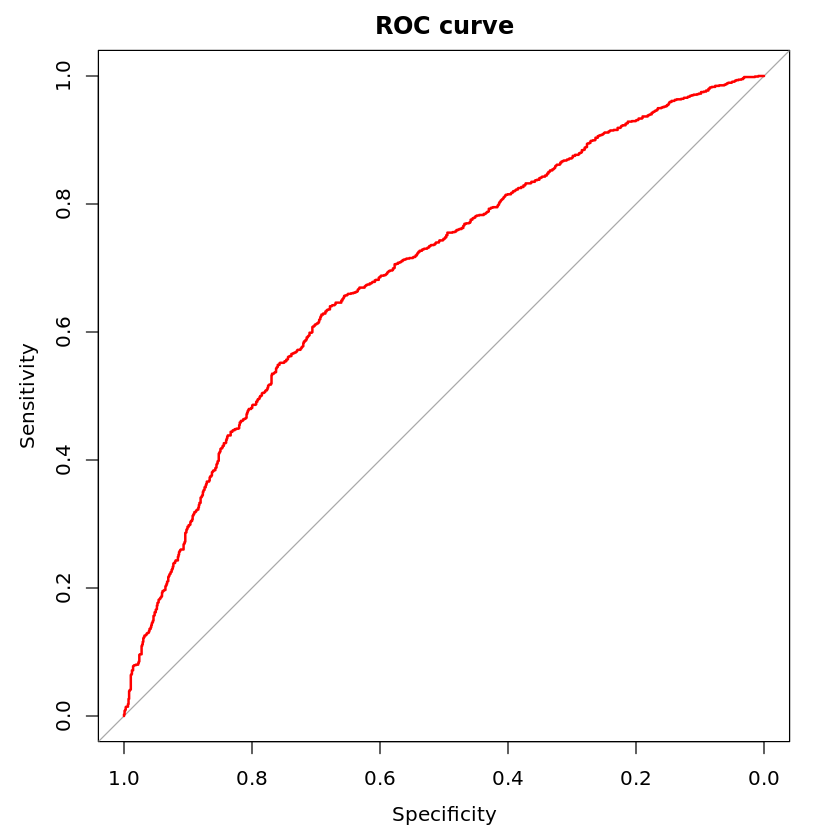

In [6]:
# run step-wise AIC
library(MASS);  
glm_fitted  <- stepAIC(glm_fitted )

X <- fitted(glm_fitted, type="response")
Tr <- dat$aline_flag

library("pROC")    
roccurve <- roc(Tr ~ X)
plot(roccurve, col=rainbow(7), main="ROC curve", xlab="Specificity", ylab="Sensitivity")
auc(roccurve)

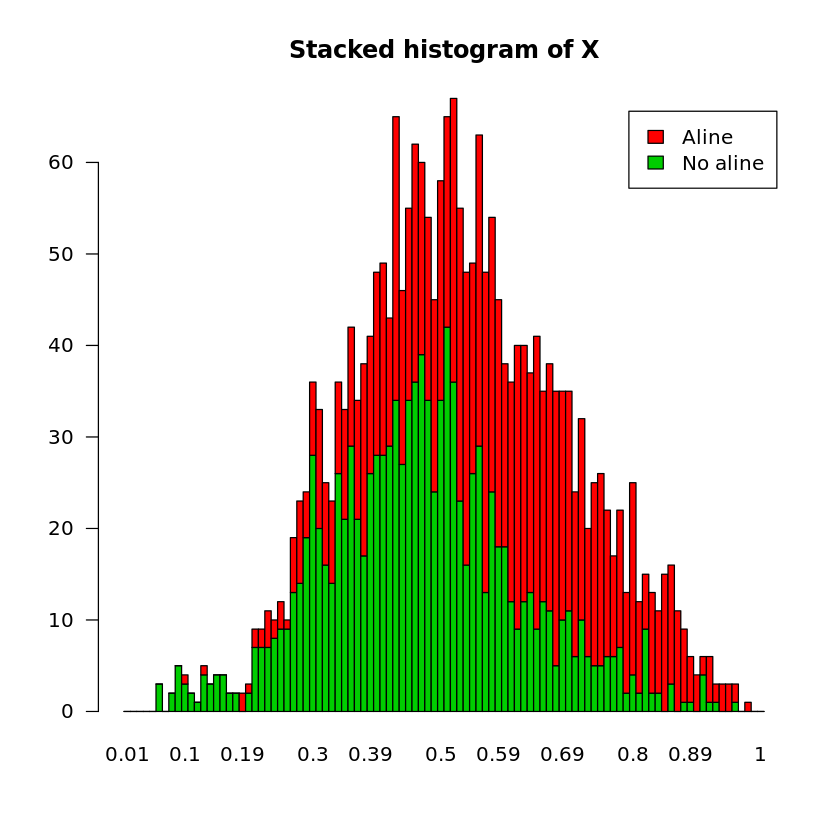

In [7]:
# plot stacked histogram of the predictions
xrange = seq(0,1,0.01)
# 3) subset your vectors to be inside xrange
g1 = subset(X,Tr==0)
g2 = subset(X,Tr==1)

# 4) Now, use hist to compute the counts per interval
h1 = hist(g1,breaks=xrange,plot=F)$counts
h2 = hist(g2,breaks=xrange,plot=F)$counts

barplot(rbind(h1,h2),col=3:2,names.arg=xrange[-1],
        legend.text=c("No aline","Aline"),space=0,las=1,main="Stacked histogram of X")

In [8]:
library(Matching)

set.seed(43770)

ps <- Match(Y=NULL, Tr=Tr, X=X, M=1, estimand='ATT', caliper=0.1, exact=FALSE, replace=FALSE);

# get pairs with treatment/outcome as cols
outcome <- data.frame(aline_pt=y[ps$index.treated], match_pt=y[ps$index.control])
head(outcome)

# mcnemar's test to see if iac related to mort (test should use matched pairs)
tab.match1 <- table(outcome$aline_pt,outcome$match_pt,dnn=c("Aline","Matched Control"))
tab.match1
tab.match1[1,2]/tab.match1[2,1]
paste("95% Confint", round(exp(c(log(tab.match1[2,1]/tab.match1[1,2]) - qnorm(0.975)*sqrt(1/tab.match1[1,2] +1/tab.match1[2,1]),log(tab.match1[2,1]/tab.match1[1,2]) + qnorm(0.975)*sqrt(1/tab.match1[1,2] +1/tab.match1[2,1])) ),2))
mcnemar.test(tab.match1) # for 1-1 pairs

## 
##  Matching (Version 4.9-6, Build Date: 2019-04-07)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##

Warning message in Match(Y = NULL, Tr = Tr, X = X, M = 1, estimand = "ATT", caliper = 0.1, :
“replace==FALSE, but there are more (weighted) treated obs than control obs.  Some treated obs will not be matched.  You may want to estimate ATC instead.”

aline_pt,match_pt
0,0
0,0
0,0
0,0
1,0
0,0


     Matched Control
Aline   0   1
    0 582 116
    1  98  26

[1] 1.183673

[1] "95% Confint 0.65" "95% Confint 1.11"


	McNemar's Chi-squared test with continuity correction

data:  tab.match1
McNemar's chi-squared = 1.3505, df = 1, p-value = 0.2452
